# Logistic Regression

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import re
import seaborn as sns
import random
import warnings
from scipy.optimize import minimize

warnings.simplefilter(action='ignore', category=FutureWarning)

np.random.seed(42)
plt.style.use('fivethirtyeight')
sns.set()
sns.set_context("talk")

# Set some parameters
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 16
np.set_printoptions(4)

%matplotlib inline

plt.rcParams['figure.figsize'] = (4, 4)
plt.rcParams['figure.dpi'] = 150
plt.rcParams['lines.linewidth'] = 3
sns.set()

In [2]:
df = pd.read_csv('nba.csv')
df["WON"] = df["WL"].replace("W", 1).replace("L", 0)
df = df.drop('WL', axis=1)
df.head()

SEASON_ID     TEAM_ID TEAM_ABBREVIATION               TEAM_NAME   GAME_ID  \
0      22018  1610612744               GSW   Golden State Warriors  21800002   
1      22018  1610612760               OKC   Oklahoma City Thunder  21800002   
2      22018  1610612755               PHI      Philadelphia 76ers  21800001   
3      22018  1610612738               BOS          Boston Celtics  21800001   
4      22018  1610612750               MIN  Minnesota Timberwolves  21800010   

    GAME_DATE      MATCHUP  MIN  FGM  FGA  ...  REB  AST  STL  BLK  TOV  PF  \
0  2018-10-16  GSW vs. OKC  240   42   95  ...   58   28    7    7   21  29   
1  2018-10-16    OKC @ GSW  240   33   91  ...   45   21   12    6   15  21   
2  2018-10-16    PHI @ BOS  240   34   87  ...   47   18    8    5   16  20   
3  2018-10-16  BOS vs. PHI  240   42   97  ...   55   21    7    5   15  20   
4  2018-10-17    MIN @ SAS  240   39   91  ...   46   20    9    2   11  27   

   PTS  PLUS_MINUS  VIDEO_AVAILABLE  WON  
0  108           8                1    1  
1  100          -8                1    0  
2   87         -18                1    0  
3  105          18                1    1  
4  108          -4                1    0  

[5 rows x 29 columns]

## 1D Logistic Regression Model

I want to start by building a model that predicts the winning probability as a function of the number of points that a team scored. The prediction of the model is $ \hat{y} = \sigma(x \hat{\theta})$, where both $x$ and $\hat{\theta}$ are scalars, not vector. $\sigma = \frac{1}{1 + e^{-t}}$ 

In [3]:
def sigma(t):
    return 1 / (1 + (np.e**(-t)))


def predicted_probability_of_winning_given_pts(pts, theta):
    return sigma(pts/100) * (pts * theta)

predicted_probability_of_winning_given_pts(100, 0.01)

0.7310585786300049

### Exploring an Example Model

Mean Probability: 0.8389919819514104


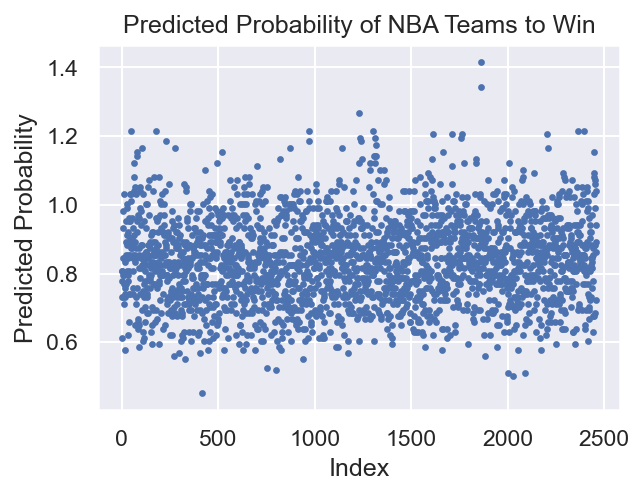

In [9]:
# Suppose theta = 0.01 I can generate predictions for each of the games in the real world dataset
# But the mean probability for each team to win is above 0.50 so there is an issue
theta = 0.01
x = df["PTS"]
y_obs = df["WON"]
y_hat = predicted_probability_of_winning_given_pts(x, theta)
print("Mean Probability:", y_hat.mean())

# plot predicted probability using index on the x axis 
plt.figure(figsize=(4,3))
plt.scatter(df.index, y_hat, s=5)
plt.xlabel("Index")
plt.ylabel("Predicted Probability")
plt.title("Predicted Probability of NBA Teams to Win");

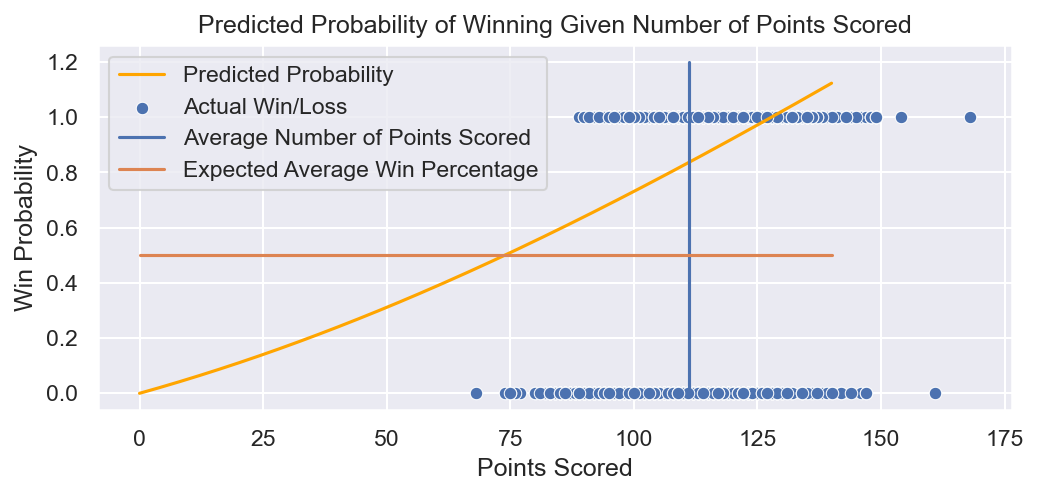

In [45]:
# plot prediction the model as a function of number of points scored for theta = 0.01 to see whats going on
theta = 0.01
pts = np.linspace(0, 140, 140)
plt.figure(figsize=(7,3))
sns.lineplot(x = pts, y = predicted_probability_of_winning_given_pts(pts, theta), color = 'orange', label='Predicted Probability')
sns.scatterplot(x = df["PTS"], y = df["WON"], label='Actual Win/Loss')
plt.plot([np.mean(df['PTS']), np.mean(df['PTS'])], [0, 1.2], label='Average Number of Points Scored')
plt.plot([0, 140], [0.5, 0.5], label='Expected Average Win Percentage')
plt.title("Predicted Probability of Winning Given Number of Points Scored")
plt.ylabel("Win Probability")
plt.xlabel("Points Scored")
plt.legend(loc='upper left');

This model is clearly not reasonable because it would be expected that half of the teams win percentage to be below 0.5 and half above. The mean win probability should be 0.5 and the mean number of points would be near that 0.5 probability. Additonally, the model exceeds a probability of 1 at about 130 points, when points typically max out around 150 with a few exceptions going above.

I could play around with the theta a bit but no matter what the models are all pretty bad. Thats beacause this is a pretty difficult model to predict because most teams score around the same amount of points. A team can win with less than 100 points in one game and in another game a team could lose with 140, because the model looks at total points of each team for each game.

### Logistic Regression with an Intercept Term

Logistic regression in 1 variable is given by $\hat{y} = \sigma(x \hat{\theta})$, whereas multiple logistic regression is given by $\hat{y} = \sigma(\vec{x} \cdot \vec{\hat{\theta}}) = \sigma(\vec{x}^T \vec{\hat{\theta}}) = \sigma(\sum_{i = 1}^p x_i \hat{\theta}_i)$.

To deal with the issues of the previous model, I add another feature, an intercept, to the model. To do this I add a column of $1$'s named `bias` to the features, X, that will serve as a constant to find the intercept. then alter the predicted_probability_of_winning_given_pts functions to take multiple features. 

In [39]:
points_and_bias = df[["PTS"]].copy()
points_and_bias["bias"] = np.ones(len(points_and_bias))

def predicted_probability_of_winning_given_features(X, theta):
    # multiple logistic regression
    return sigma(np.sum(theta * X, axis=1))
    
predicted_probability_of_winning_given_features(points_and_bias.iloc[:3, :], [0.1, -10])

0    0.689974
1    0.500000
2    0.214165
dtype: float64

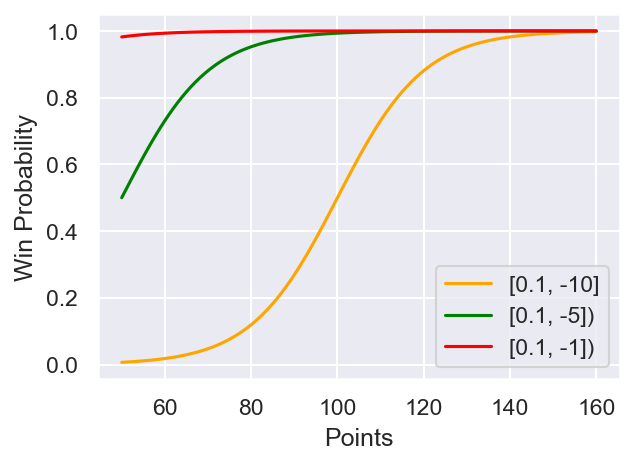

In [67]:
# The intercept 
theta = [0.05, -5]
pts = np.linspace(50, 160, 111).reshape(-1, 1)
bias = np.ones(len(pts)).reshape(-1, 1)
point_range_and_bias = np.hstack((pts, bias))
probs1 = predicted_probability_of_winning_given_features(point_range_and_bias, [0.1, -10])
probs2 = predicted_probability_of_winning_given_features(point_range_and_bias, [0.1, -5])
probs3 = predicted_probability_of_winning_given_features(point_range_and_bias, [0.1, -1])
plt.figure(figsize=(4,3))
sns.lineplot(x = np.linspace(50, 160, 111), y = probs1, color = 'orange', label='[0.1, -10]')
sns.lineplot(x = np.linspace(50, 160, 111), y = probs2, color = 'green', label='[0.1, -5])')
sns.lineplot(x = np.linspace(50, 160, 111), y = probs3, color = 'red', label='[0.1, -1])')
plt.ylabel("Win Probability")
plt.xlabel("Points")
plt.legend();

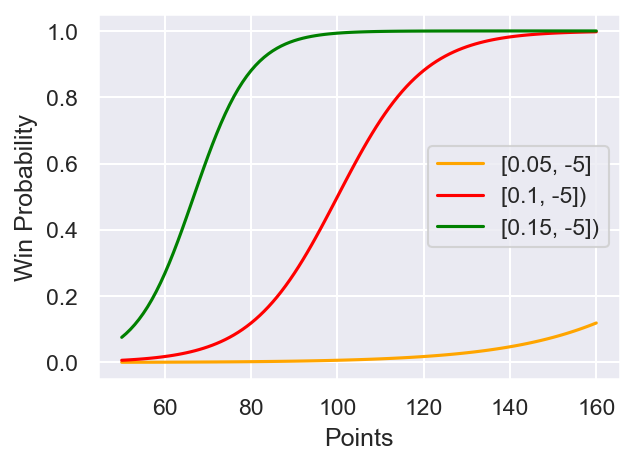

In [68]:
# The slope
point_range_and_bias = np.hstack((pts, bias))
probs1 = predicted_probability_of_winning_given_features(point_range_and_bias, [0.05, -10])
probs2 = predicted_probability_of_winning_given_features(point_range_and_bias, [0.15, -10])
probs3 = predicted_probability_of_winning_given_features(point_range_and_bias, [0.1, -10])
plt.figure(figsize=(4,3))
sns.lineplot(x = np.linspace(50, 160, 111), y = probs1, color = 'orange', label='[0.05, -5]')
sns.lineplot(x = np.linspace(50, 160, 111), y = probs3, color = 'red', label='[0.1, -5])')
sns.lineplot(x = np.linspace(50, 160, 111), y = probs2, color = 'green', label='[0.15, -5])')
plt.ylabel("Win Probability")
plt.xlabel("Points")
plt.legend();

Changing the $\theta_1$ changes how fast the line increases. Decreasing $\theta_1$ makes the line increase quicker and incresing $\theta_2$ decreases how fast the line is going up. Changing the $\theta_2$ changes where the plot crosses the y axis.

    points     probs
30    80.0  0.017986
50   100.0  0.500000
70   120.0  0.982014


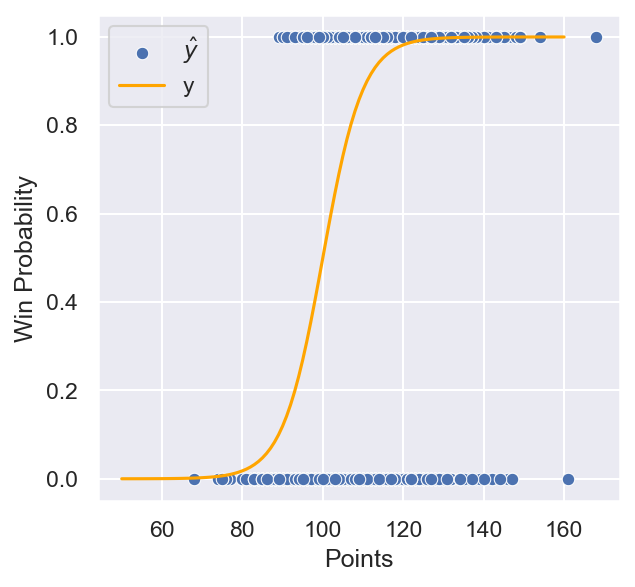

In [88]:
# The parameters [0.2, -20] give me a  a sharp curve that is centered at 100 points 
sns.scatterplot(x = df["PTS"], y = df["WON"])

theta = [0.2, -20]
pts = np.linspace(50, 160, 111)
bias = np.ones(len(pts))
probs = predicted_probability_of_winning_given_features(point_range_and_bias, theta)
d = pd.DataFrame({'points': pts, 'probs':probs})

print(d[(d['points']==80) | (d['points']==100) | (d['points']==120)])

sns.lineplot(x = pts, y = probs, color = 'orange')
plt.ylabel("Win Probability")
plt.xlabel("Points")
plt.legend(['$\hat{y}$', 'y']);

### Optimizing Logistic Regresion

I now want to find the optimal theta $\hat{\theta}$ for the given data by minimizing mean squared error using `scipy.optimize.minimize`.

In [94]:
def mse(y_obs, y_hat):
    return np.sum((y_obs-y_hat)**2)/len(y_obs)

def mse_for_model_on_NBA_data(theta):
    y_hat = predicted_probability_of_winning_given_features(points_and_bias, theta)
    y_obs = df['WON']
    return mse(y_obs, y_hat)

optimal_theta = minimize(mse_for_model_on_NBA_data, [0, 0])
optimal_theta['x']

array([  0.0995, -11.0282])

For the model to be practically useful I need to convert the logistic regression models into a concrete prediction by thresholding. That is, if $\hat{y} \geq 0.5$, the prediction is that the team will win; otherwise, the prediction is they will lose. A simple way to do this is just to round $\hat{y}$.

In [105]:
probs = predicted_probability_of_winning_given_features(points_and_bias, [optimal_theta['x'][0], optimal_theta['x'][1]]) 
df['PRED_WON']= np.round(probs)

print("The model predicts correctly", len(df[df['WON'] == df['PRED_WON']]) / len(df), "of the time")
df.head(3)

The model predicts correctly 0.7109756097560975 of the time


SEASON_ID     TEAM_ID TEAM_ABBREVIATION              TEAM_NAME   GAME_ID  \
0      22018  1610612744               GSW  Golden State Warriors  21800002   
1      22018  1610612760               OKC  Oklahoma City Thunder  21800002   
2      22018  1610612755               PHI     Philadelphia 76ers  21800001   

    GAME_DATE      MATCHUP  MIN  FGM  FGA  ...  AST  STL  BLK  TOV  PF  PTS  \
0  2018-10-16  GSW vs. OKC  240   42   95  ...   28    7    7   21  29  108   
1  2018-10-16    OKC @ GSW  240   33   91  ...   21   12    6   15  21  100   
2  2018-10-16    PHI @ BOS  240   34   87  ...   18    8    5   16  20   87   

   PLUS_MINUS  VIDEO_AVAILABLE  WON  PRED_WON  
0           8                1    1       0.0  
1          -8                1    0       0.0  
2         -18                1    0       0.0  

[3 rows x 30 columns]

MSE surface has a huge almost completely flat region, which means that the loss function is very difficult to optimize. An alternate loss function called the cross-entropy loss gets a much nicer loss surface (no big flat regions).

The loss function for cross-entropy is $R(\theta) = -\frac{1}{n}\sum_{i = 1}^{n}(y_{i}\log(\hat{y})) + (1-y_{i})\log(1-\hat{y}))$

In [108]:
def cel(y_obs, y_hat):
    # have to add 1e-15 to avoid 1og(0)
    sum = - y_obs * np.log(y_hat + 1e-15) + (1 - y_obs) * np.log(1 - y_hat + 1e-15)
    return np.sum(sum) / len(y_obs)

def cel_for_model_on_NBA_data(theta):
    y_hat = predicted_probability_of_winning_given_features(points_and_bias, theta)
    y_obs = df['WON']
    return cel(y_obs, y_hat)

optimal_theta = minimize(cel_for_model_on_NBA_data, [0, 0])
optimal_theta['x']

array([1.01  , 0.0091])

### Higher Dimensional Models

Now I will train a logistic regression model on all useful fields. I won't include the difference in the number of points between the two teams, otherwise the logistic regression will be right 100% of the time since a team wins if and only if PLUS_MINUS > 0.

In [126]:
df_num_fields = df.loc[:, 'FGM':'PTS']
df_num_fields["BIAS"] = np.ones(len(df_num_fields))

def predicted_probability_of_winning_given_all(X, theta):
    # multiple logistic regression
    return sigma(np.sum(theta * X, axis=1))

def mse_for_model_on_full_data(theta):
    y_hat = predicted_probability_of_winning_given_all(df_num_fields, theta)
    y_obs = df['WON']
    return mse(y_obs, y_hat)

optimal_theta = minimize(mse_for_model_on_full_data, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
print("Optimal Thetas:", optimal_theta['x'])

probs = predicted_probability_of_winning_given_features(df_num_fields, optimal_theta['x']) 
df['PRED_WON']= np.round(probs)

print("The model predicts correctly", len(df[df['WON'] == df['PRED_WON']]) / len(df), "of the time")

Optimal Theta: [ 2.1245e+00 -4.5122e-01 -2.1908e+01  9.2335e-01 -3.5700e-03  2.7238e+00
  8.8296e-01 -7.1640e-02  2.1084e+00  3.0395e-01  3.2464e-01  4.9600e-02
  1.9550e-02  3.8726e-01  6.9640e-02 -3.1120e-01 -5.5790e-02 -7.5485e-01
  5.1960e+00]
The model predicts correctly 0.8434959349593496 of the time


In [137]:
pd.DataFrame({"Field": df_num_fields.columns, "Theta": optimal_theta['x'], 
              "|Theta|": np.abs(optimal_theta['x'])}).drop(18).sort_values('|Theta|', ascending=False).head()

Field      Theta    |Theta|
2   FG_PCT -21.907822  21.907822
5  FG3_PCT   2.723832   2.723832
0      FGM   2.124515   2.124515
8   FT_PCT   2.108430   2.108430
3     FG3M   0.923354   0.923354

FG_PCT had by far the highest effect of a predicted win. FG3_PCT, FGM, FT_PCT also seem to play a somewhat significant role in predicting a win. 